In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from poker_utils.constants import HANDS_DICT
from poker_utils.model import analyze_embeddings, save_model_and_embeddings, plot_train_loss, prob_embeddings

In [2]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")

In [3]:
equity_cols = [
    'tot_win_perc', 'high_card_win_perc', 'one_pair_win_perc', 
    'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential'
    ]

blocker_cols = [
    'prem_blocker_score_norm', 'block_aa_score', 'block_kk_score',
]

base_cols = [#"suited"
    # 'suited', 'pair', 'ace', 'broadway_score', 
    # 'low_pair', 'medium_pair', 'high_pair', 
    # 'suited_broadway_score', 
    # 'connector', 'one_gap', 'two_gap', 
    # 'suited_connector', 'suited_one_gap', 'suited_two_gap',
    # 'connectedness_score', 'rank_diff_score', 'high_card_score',
    # 'low_card_score', 'suited_connected_score'
    ]

In [4]:
full_data = pd.concat(
    [base_data[base_cols], 
     blocker_data[blocker_cols], 
     equity_data[equity_cols], 
     ev_data], axis=1)

In [5]:
handhand_data = pd.read_csv("data/processed/handhand_equity.csv")
handhand_data['equity_diff'] = handhand_data.hand1_equity - handhand_data.hand2_equity
handhand_data['rank'] = np.where(handhand_data['equity_diff'] > 0,1,-1)



In [6]:
class EquityDiffDataset:
    def __init__(self, feature_data, handhand_equity, train=None):
        self.train = train
        self.hands = feature_data.index
        self.feature_data = feature_data
        if train is not None:
            train_data, val_data = train_test_split(
                handhand_equity,
                test_size=0.3, 
                stratify=handhand_equity['rank'],
                random_state=29
                )

            if train == True: 
                self.data = train_data
            elif train == False:
                self.data = val_data
        else:
            self.data = feature_data
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.train is not None:
            row = self.data.iloc[idx]
            hand1 = row['hand1']
            hand2 = row['hand2']
            hand1_features = self.feature_data.loc[hand1].to_numpy()
            hand2_features = self.feature_data.loc[hand2].to_numpy()
            equity_diff = row['equity_diff']
            rank = row['rank']
            
            return (
                torch.tensor(hand1_features, dtype=torch.float32),
                torch.tensor(hand2_features, dtype=torch.float32),
                torch.tensor(equity_diff, dtype=torch.float32),
                torch.tensor(rank, dtype=torch.float32),
            )
        else:
            return torch.tensor(self.data.iloc[idx].to_numpy(), dtype=torch.float32)
        

In [7]:
train_dataset = EquityDiffDataset(full_data, handhand_data, train=True)
val_dataset = EquityDiffDataset(full_data, handhand_data, train=False)
full_dataset = EquityDiffDataset(full_data, handhand_data)

In [8]:
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
valloader = DataLoader(val_dataset, shuffle=False, batch_size=128)
fullloader = DataLoader(full_dataset, shuffle=False, batch_size=len(full_dataset))

In [9]:
def train_rank_model(model, trainloader,  valloader,  rank_loss_func,  optimizer, scheduler, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for hand1_feat, hand2_feat, equity_diff, rank in trainloader:
            optimizer.zero_grad()
            rank = rank.unsqueeze(1)
            hand1_rank_emb, hand1_score = model(hand1_feat)
            hand2_rank_emb, hand2_score = model(hand2_feat)
            rank_loss = rank_loss_func(hand1_score, hand2_score, rank)
            
            rank_loss.backward()
            optimizer.step()
            
            tot_train_loss += rank_loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for hand1_feat, hand2_feat, equity_diff, rank in valloader:
                rank = rank.unsqueeze(1)
                hand1_rank_emb, hand1_score = model(hand1_feat)
                hand2_rank_emb, hand2_score = model(hand2_feat)
                rank_loss = rank_loss_func(hand1_score, hand2_score, rank)
                tot_val_loss += rank_loss.item()
        avg_val_loss = tot_val_loss / len(trainloader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)
            
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses



In [10]:
class RankModel(nn.Module):
    def __init__(self, input_size=90, embedding_dim=8):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128), 
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, embedding_dim)
            )

        self.rank_head = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        rank_emb = self.encoder(x)
        rank_emb = F.normalize(rank_emb, p=2, dim=1)
        score = self.rank_head(rank_emb)
        return rank_emb, score

In [11]:
rank_model = RankModel(input_size=71, embedding_dim=16)
optimizer = torch.optim.Adam(params=rank_model.parameters(), lr=0.001, weight_decay=1e-5)
rank_loss_func = nn.MarginRankingLoss(margin=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


Epoch 1/15, Train Loss: 0.0206, Val Loss: 0.0070
Epoch 4/15, Train Loss: 0.0133, Val Loss: 0.0062
Epoch 7/15, Train Loss: 0.0122, Val Loss: 0.0073
Epoch 10/15, Train Loss: 0.0109, Val Loss: 0.0059
Epoch 13/15, Train Loss: 0.0108, Val Loss: 0.0063
Epoch 15/15, Train Loss: 0.0106, Val Loss: 0.0053


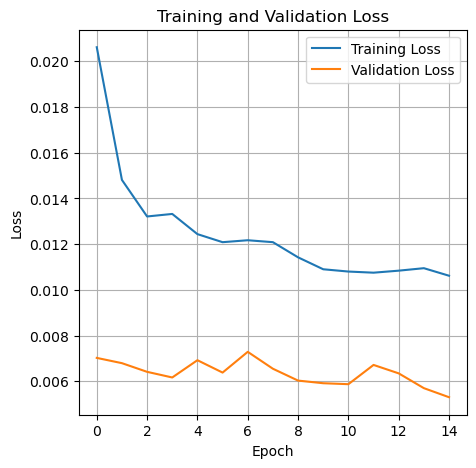

In [12]:
rank_train_losses, rank_val_losses = train_rank_model(
    rank_model, 
    trainloader, 
    valloader, 
    rank_loss_func, 
    optimizer,
    scheduler,
    epochs=15
    )

plot_train_loss(rank_train_losses, rank_val_losses)


In [13]:
rank_model.eval()
all_hands = next(iter(fullloader))
with torch.no_grad():
    rank_emb, score = rank_model(all_hands)
    rank_emb = F.normalize(rank_emb, p=2, dim=1)

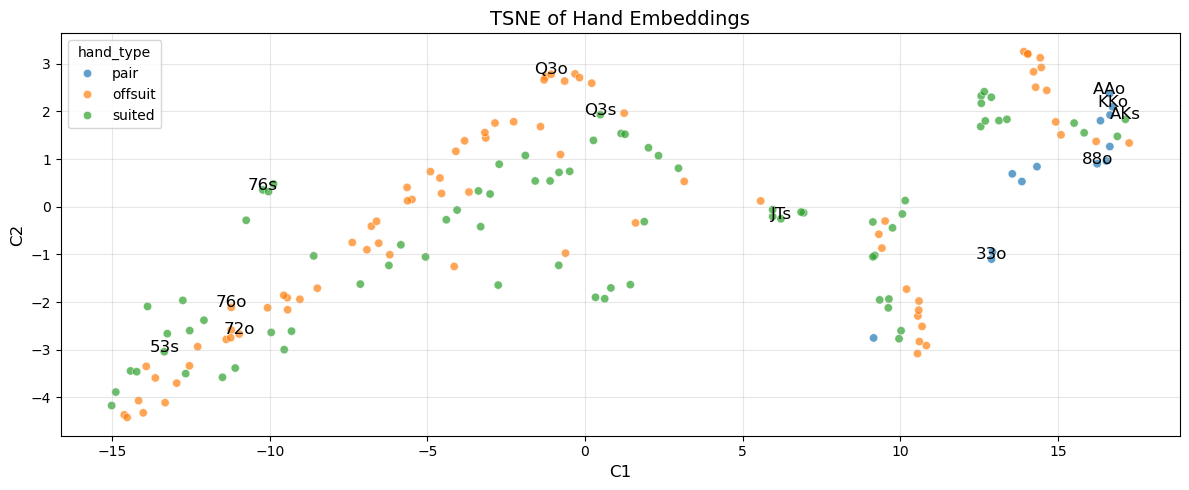

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9905)  QQo (0.9828)  JJo (0.9733)  42o (-0.9633)   
1   KKo  QQo (0.9961)  AAo (0.9905)  JJo (0.9877)  42o (-0.9590)   
2   72o  73o (0.9978)  74o (0.9948)  75o (0.9898)  AKs (-0.6524)   
3   76s  86s (0.9690)  75s (0.9562)  87s (0.9364)  KKo (-0.4277)   
4   76o  75o (0.9917)  74o (0.9903)  73o (0.9884)  AKs (-0.6269)   
5   Q3s  Q4s (0.9835)  Q2s (0.9830)  Q9o (0.9817)  32o (-0.1293)   
6   Q3o  Q4o (0.9991)  Q2o (0.9987)  Q5o (0.9963)  32o (-0.0390)   
7   88o  99o (0.9925)  TTo (0.9830)  AQo (0.9807)  32o (-0.9306)   
8   JTs  J9s (0.9716)  Q9s (0.9383)  QTs (0.9217)  42o (-0.3656)   
9   33o  44o (0.9430)  22o (0.8148)  A7o (0.8047)  32o (-0.5626)   
10  AKs  KKo (0.9830)  AKo (0.9802)  QQo (0.9800)  32o (-0.9371)   
11  53s  64s (0.9880)  54o (0.9868)  53o (0.9868)  AKs (-0.8391)   

         bottom_2       bottom_3  
0   32s (-0.9702)  42s (-0.9707)  
1   42s (-0.9681)  32s (-0.9715)  
2   KKo (-

In [14]:
similarity_df = analyze_embeddings(
    rank_emb, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

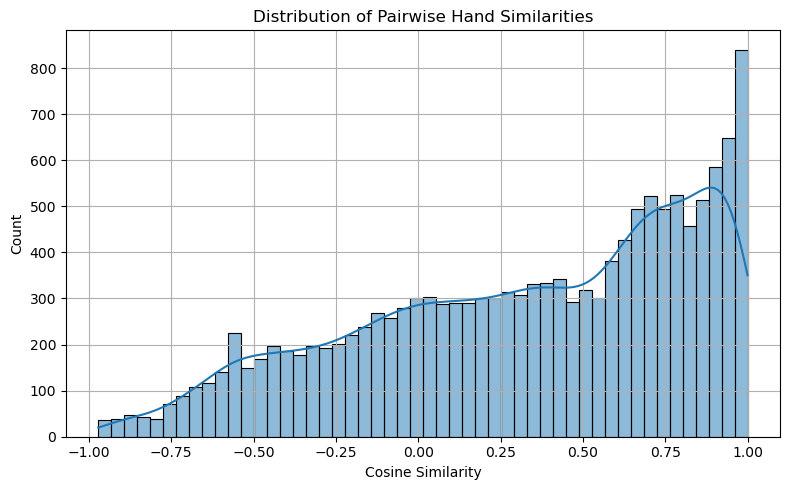

In [15]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
equity_matrix = np.zeros((169,169))
np.fill_diagonal(equity_matrix, np.ones((169))*0.5)

In [17]:
handhand_data['hand1_idx'] = handhand_data['hand1'].apply(
    lambda x:{j:i for i, j in HANDS_DICT.items()}[x])
handhand_data['hand2_idx'] = handhand_data['hand2'].apply(
    lambda x:{j:i for i, j in HANDS_DICT.items()}[x])

In [18]:
for i, row in handhand_data.iterrows():
    equity_matrix[row['hand1_idx'], row['hand2_idx']] = row['hand1_equity']
    equity_matrix[row['hand2_idx'], row['hand1_idx']] = row['hand2_equity']

In [19]:
score_np = score.detach().cpu().numpy().flatten()
avg_equity = np.zeros(169)
for hand in range(169):
    equities = [equity_matrix[hand][other_hand] for other_hand in range(169) if hand != other_hand]
    avg_equity[hand] = sum(equities) / len(equities)
    
rank_df = pd.DataFrame({
    'hands': full_dataset.hands,
    'avg_equity': avg_equity,
    'pred_rank': score_np
})
correlation, p_value = spearmanr(rank_df['pred_rank'], rank_df['avg_equity'])
print(f"Rank Correlation: {correlation:.4f} (p-value: {p_value:.4f})")

Rank Correlation: 0.9619 (p-value: 0.0000)


In [20]:
correct = 0
total = 0
incorrect_pairs = set()
for hand1 in range(169):
    for hand2 in range(hand1+1, 169):
        total += 1
        true_hand1_beats_hand2 = equity_matrix[hand1][hand2] > 0.5
        pred_hand1_beats_hand2 = score_np[hand1] > score_np[hand2]
        if true_hand1_beats_hand2 == pred_hand1_beats_hand2:
            correct += 1
        else:
            incorrect_pairs.add(tuple(sorted((hand1,hand2))))
accuracy = correct / total
print(f"Pairwise accuracy: {accuracy:.4f} ({correct}/{total} pairs correct)")

Pairwise accuracy: 0.9637 (13681/14196 pairs correct)


In [21]:
prob_data = prob_embeddings(rank_emb, base_data)

In [22]:
prob_data[prob_data.attribute=='suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
0,suited,0,0.881657,0.908046,0.868132,0.88764,0.538462
1,suited,1,0.881657,0.853659,0.897436,0.87500,0.461538


In [23]:
prob_data[prob_data.attribute=='connectedness']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
2,connectedness,0,0.378698,0.764706,1.000000,0.866667,0.076923
3,connectedness,1,0.378698,0.531250,0.653846,0.586207,0.153846
4,connectedness,2,0.378698,0.500000,0.250000,0.333333,0.142012
5,connectedness,3,0.378698,0.263158,0.227273,0.243902,0.130178
6,connectedness,4,0.378698,0.240000,0.300000,0.266667,0.118343
7,connectedness,5,0.378698,0.272727,0.333333,0.300000,0.106509
8,connectedness,6,0.378698,0.272727,0.187500,0.222222,0.094675
9,connectedness,7,0.378698,0.181818,0.200000,0.190476,0.059172
10,connectedness,8,0.378698,0.272727,0.375000,0.315789,0.047337
11,connectedness,9,0.378698,1.000000,0.166667,0.285714,0.035503


In [27]:
prob_data[prob_data.attribute=='broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
60,broadway,0,0.940828,1.000000,0.9375,0.967742,0.378698
61,broadway,1,0.940828,0.939759,0.9750,0.957055,0.473373
62,broadway,2,0.940828,0.807692,0.8400,0.823529,0.147929


In [24]:
prob_data[prob_data.attribute=='pair']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
14,pair,0,0.988166,0.987342,1.000000,0.993631,0.923077
15,pair,1,0.988166,1.000000,0.846154,0.916667,0.076923


In [25]:
prob_data[prob_data.attribute=='connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
72,connector,0,0.869822,0.871166,0.993007,0.928105,0.846154
73,connector,1,0.869822,0.833333,0.192308,0.312500,0.153846


In [26]:
prob_data[prob_data.attribute=='suited_connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
78,suited_connector,0,0.934911,0.934132,1.000000,0.965944,0.923077
79,suited_connector,1,0.934911,1.000000,0.153846,0.266667,0.076923


In [ ]:
# save_model_and_embeddings(
#     rank_emb,
#     'preflop_embeddings_rank',
#     rank_model,
#     "preflop_rank_encoder_weights"
#     )